<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/Kalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 228 kB 7.9 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=2f19220846b679520d4235d37c048bdf04a60b88a7d2b18c5362fdceb723b446
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman
     |████████████████████████████████| 6.3 MB 9.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 88 kB 4.6 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=73e4ca4f8e059957d516632672bf9416915cf3eeed16d3d162f81325a7c36a78
  Stored in directory: /root/.cache/pip/wheels/b1/49/60/e674e28ae57160651c6198b76e1714a0b175e44e022fcd5137
Successfully built pandas-ta


In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


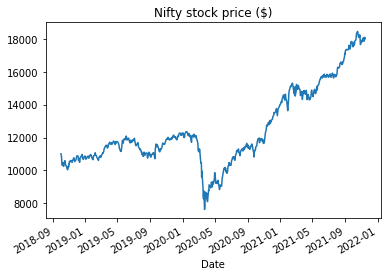

In [3]:
nifty_df = yf.download('^nsei',start='2018-10-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [4]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [5]:
df = nifty_df[['Adj Close']]


mean 16007.635609732139


Text(0.5, 0, 'Days')

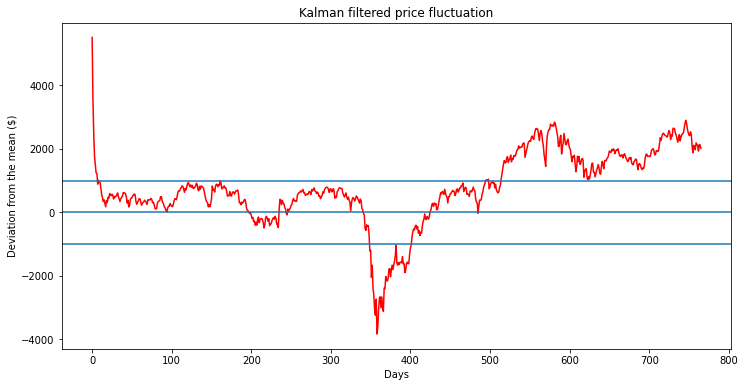

In [6]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [7]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [8]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [9]:
nifty=nifty.set_index('date')

In [10]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-11-15,2122.091896,2307.734850,310.906667,2463.188183,2152.281516,-1.386614,-69.102213,67.715599
2021-11-16,2017.714000,2269.268348,295.704113,2417.120405,2121.416291,-9.301096,-68.909675,59.608578


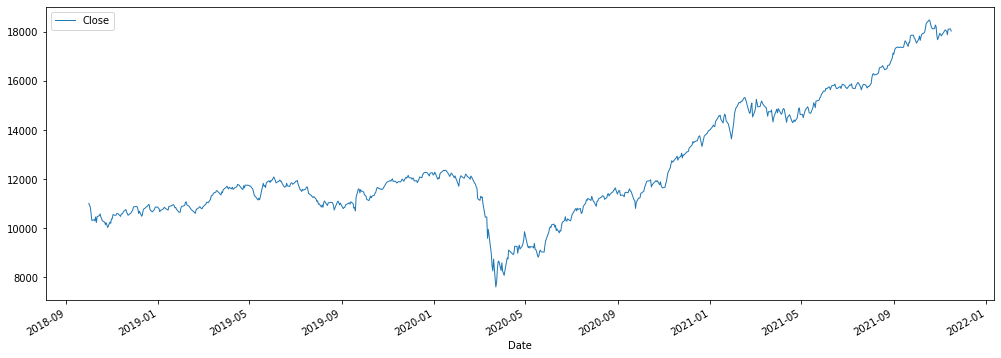

In [11]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

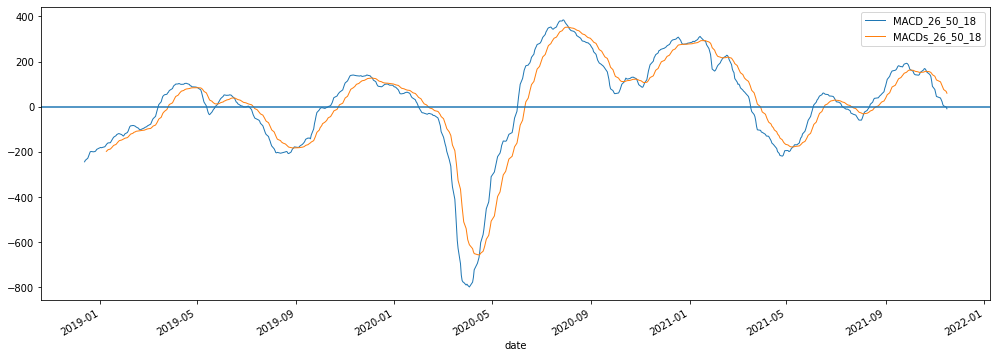

In [12]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

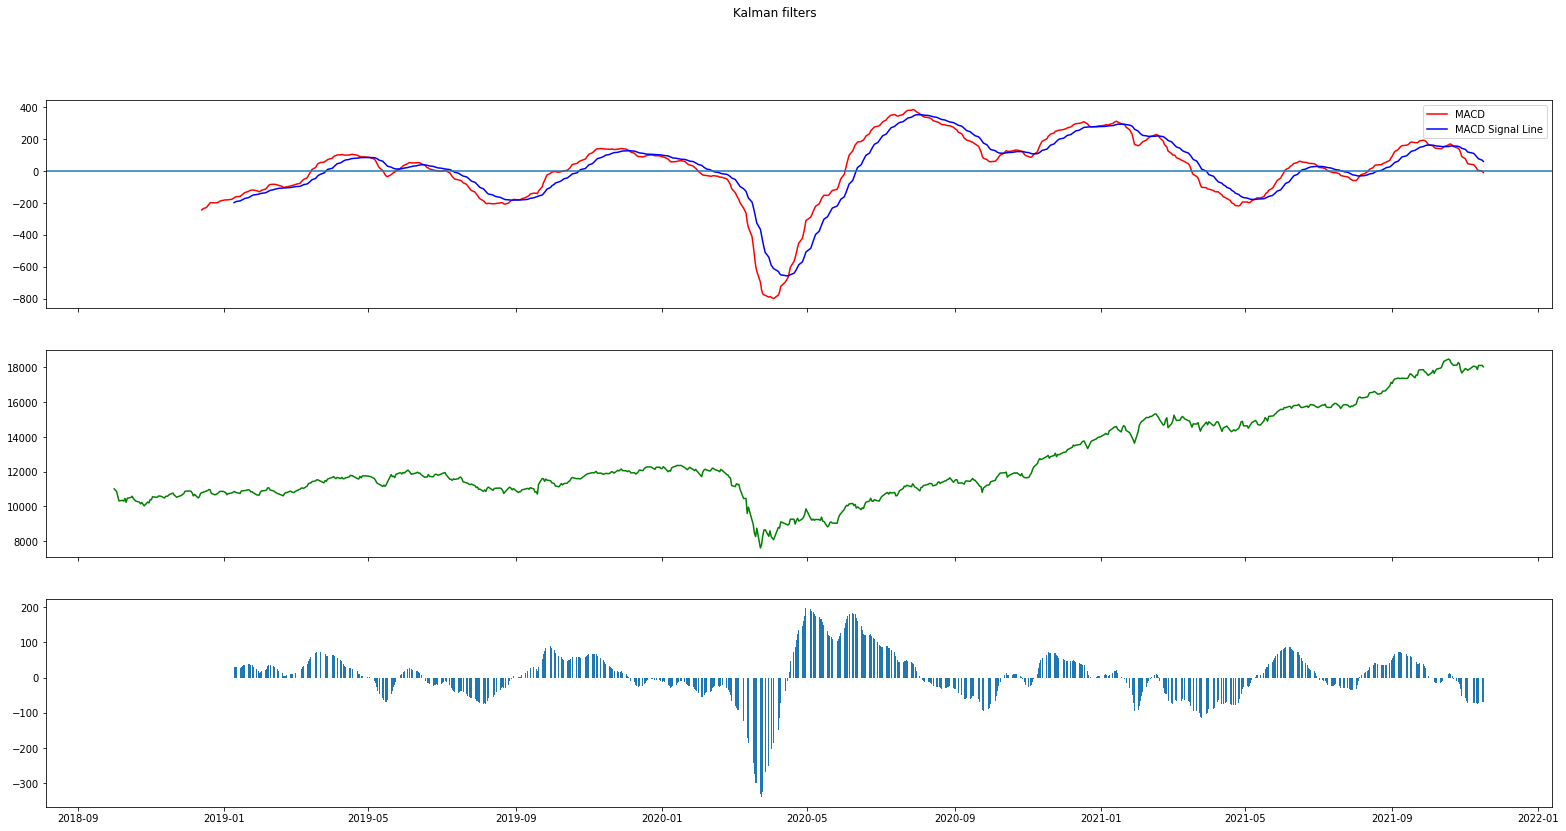

In [13]:
fig, ax = plt.subplots(3,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_26_50_18'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_26_50_18'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_26_50_18'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[0].legend()
plt.show()


In [14]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-11-16,2017.714,2269.268348,295.704113,2417.120405,2121.416291,-9.301096,-68.909675,59.608578


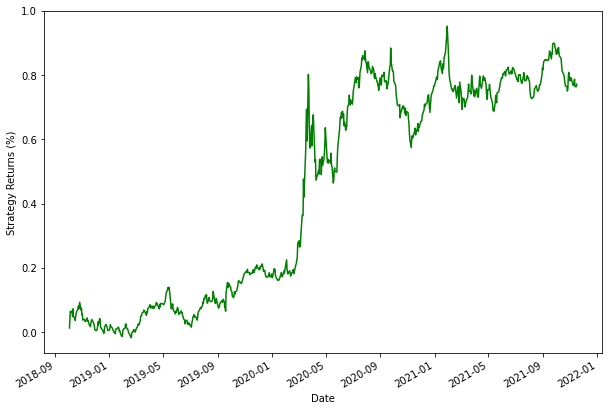

sharpe ratio :  0.07498708935736918
sortino ratio :  4.59470582083576


In [15]:
nifty['signals']=np.where(nifty['MACDh_26_50_18']>0,1,-1)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05)/std_neg
print('sortino ratio : ' , sortino_ratio) 

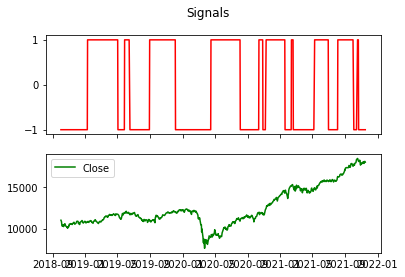

In [16]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


In [17]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,signals,Return,Strategy_F
date,,,,,,,,,,,
2021-11-15,2122.091896,2307.734850,310.906667,2463.188183,2152.281516,-1.386614,-69.102213,67.715599,-1,0.000370,-0.000370
2021-11-16,2017.714000,2269.268348,295.704113,2417.120405,2121.416291,-9.301096,-68.909675,59.608578,-1,-0.004644,0.004644


In [18]:
nifty[['signals']].to_csv('kalman.csv')